# Tensorflow CNN

A convolutional neural network written in pure tensorflow.

**Note:** this is an updated version of my [kaggle kernel](https://www.kaggle.com/flaport/tensorflow-cnn-lb-0-98929).

## Imports

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
depth = 1 # Number of colors in the image (greyscale)

# Training Parameters
num_steps = 20000   # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
batch_size = 100 # Stochastic Gradient Descent batch size

# CNN Parameters
kernel_size = 5 # Convolutional Kernel size
kernel_depth = 32 # Convolutional Kernel depth size == Number of Convolutional Kernels
num_hidden = 1024 # Number of hidden neurons in the fully connected layer

# Optimization parameters
learning_rate = 0.001 # Learning rate

## Data

We use the `fetch_mldata` from `sklearn.datasets` to fetch the MNIST data.

As a preprocessing step, the labels are converted to a one-hot encoded sparse matrix. [One hot encoding](https://en.wikipedia.org/wiki/One-hot) is just a way of replacing each integer in the label vector with a row of zeros, except at the position specified by the integer, where you put a 1.

Note that the inverse transformation of the one-hot encoding can always be performed by taking the `argmax` along `axis=1`.

Secondly, the image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In [3]:
data = fetch_mldata('MNIST original')
data = np.hstack([data['target'][:,None], data['data']])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = np.int32(data[:,0])
    labels_onehot = np.zeros((len(labels), num_labels))
    labels_onehot[np.arange(len(labels)),labels] = 1
    values = np.float32(data[:,1:]).reshape(-1, height, width, depth)/255
    return values, labels, labels_onehot

train_values, train_labels, train_labels_onehot = get_values_labels(train_data)
valid_values, valid_labels, valid_labels_onehot = get_values_labels(valid_data)
test_values, test_labels, test_labels_onehot = get_values_labels(test_data)

print(f'train data shape:\t\t{train_values.shape}')
print(f'train labels (one-hot) shape:\t{train_labels_onehot.shape}')

train data shape:		(50000, 28, 28, 1)
train labels (one-hot) shape:	(50000, 10)


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

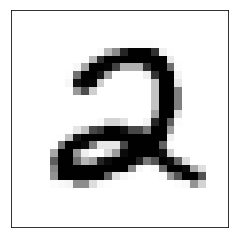

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(height, width), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

Let's now build a network with two convolutional layers, followed by two fully connected layers. We initialize the input data with placeholders:

In [5]:
tf_data = tf.placeholder(tf.float32, shape=(None, height, width, depth))
tf_labels = tf.placeholder(tf.float32, shape=(None, num_labels))

We choose a 4 layered network consisting of 2 convolutional layers with weights and biases (w1, b1) and (w2,b2), followed by a fully connected hidden layer (w3,b3) with `num_hidden` hidden neurons and an output layer (w4, b4) with `num_labels` output nodes (one-hot encoding).

We initialize the weights and biases such that the kernel size of the second convolutional layer is twice that of the kernel size of the first convolutional layer.

In [6]:
# weights & biases
w1 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, depth, kernel_depth], stddev=0.1))
b1 = tf.Variable(tf.zeros([kernel_depth]))
w2 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, kernel_depth, 2*kernel_depth], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*kernel_depth]))
w3 = tf.Variable(tf.truncated_normal([width // 4 * width // 4 * 2*kernel_depth, num_hidden], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
w4 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

# model
def model(data):
    ''' Model returning the output logits. '''
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    # Fully connected layer
    x = tf.reshape(x, (-1, width // 4 * width // 4 * 2*kernel_depth))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4



We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp


In [7]:
# prediction
tf_pred = tf.nn.softmax(model(tf_data))

# loss
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model(tf_data), labels=tf_labels))

# accuracy
tf_acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

# optimizer
#tf_opt = tf.train.GradientDescentOptimizer(learning_rate)
#tf_opt = tf.train.AdamOptimizer(learning_rate)
tf_opt = tf.train.RMSPropOptimizer(learning_rate)

# trainer
tf_step = tf_opt.minimize(tf_loss)

# Train

Open the session

In [8]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

Run the session

In [9]:
%%time
ss = ShuffleSplit(n_splits=num_steps, train_size=batch_size)
ss.get_n_splits(train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_data,train_labels), start=1):
    fd = {tf_data:train_values[idx], tf_labels:train_labels_onehot[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_values, tf_labels:valid_labels_onehot}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        clear_output(1)
        print(f'Step {step}\t Valid. Acc. = {valid_accuracy}')

Step 20000	 Valid. Acc. = 99.04000091552734
CPU times: user 2min 15s, sys: 29.9 s, total: 2min 45s
Wall time: 2min 48s


Training history:

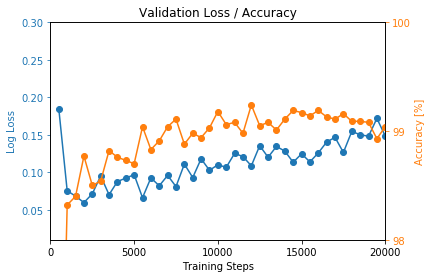

In [10]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(98,100)
plt.yticks([98,99,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
plt.ylim(0.01, 0.3)

plt.xlim(0, max(steps))
plt.xticks([0,num_steps//4, num_steps//2, 3*num_steps//4, num_steps])
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

# Test

Finally, the accuracy on the test set can be evaluated:

In [11]:
fd = {tf_data:test_values, tf_labels:test_labels_onehot}
test_accuracy = session.run(tf_acc, feed_dict=fd)
print(f'Test Accuracy = {test_accuracy}')

Test Accuracy = 99.18000030517578


Visualize an example

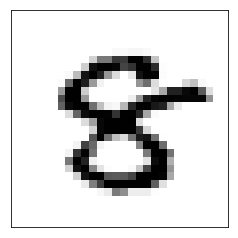

prediction=8	target=8


In [12]:
N = 315
show_digit(test_values[N])
prediction = np.argmax(session.run(tf_pred, feed_dict={tf_data:test_values[N:N+1]}).ravel())
print(f'prediction={prediction}\ttarget={test_labels[N]}')

Close the session

In [13]:
session.close()